In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load ATLAS exclusion curve

In [25]:
atlasCurve = np.genfromtxt('../ATLAS_data/HEPData-ins2080541-v1-csv/MassLimitvs.Lifetime,Chargino,Observed.csv',
                        skip_header=9,
                        names=["Lifetime [ns]","Observed Limit [GeV]","1sigmaPlus","1sigmaMinus"],
                        delimiter=',')

dtype([('Lifetime_ns', '<f8'), ('Observed_Limit_GeV', '<f8'), ('1sigmaPlus', '<f8'), ('1sigmaMinus', '<f8')])

### Load Recast Data

In [6]:
recastData = pd.read_pickle('../scanResults_Wino.pcl')
print(len(recastData))

102


In [7]:
kfactor = 1.2
muData = recastData['$\mu_{obs}$']/kfactor

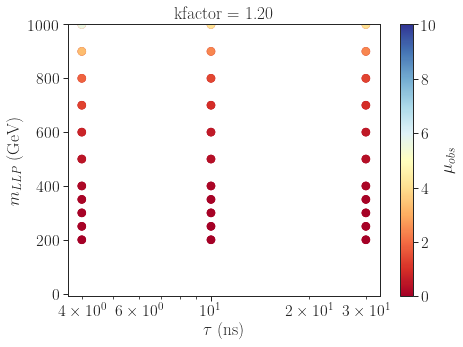

In [9]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=recastData['tau_ns'],y=recastData['mLLP'],vmin=0.0,vmax=10.0,
            c=muData,cmap=cm,s=60)
cbar = plt.colorbar(label=r'$\mu_{obs}$')
# cbar.set_ticks([-1.0,-0.6666,-0.3333,0.0,0.33333,0.66666,1.0])
# plt.plot(cmsCurve['m_med_GeV'],cmsCurve['m_chi_GeV'],label='CMS',linewidth=2,color='black')
plt.ylabel(r'$m_{LLP}$ (GeV)')
plt.xlabel(r'$\tau$ (ns)')
plt.ylim(-10,1000)
# plt.xlim(0,3000)
plt.xscale('log')
plt.title('kfactor = %1.2f' %kfactor)
# plt.text(0.1,0.7,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
#          transform = plt.gca().transAxes)
plt.show()

### Interpolate for a denser grid

In [18]:
pts = np.array([x for x in product(np.linspace(np.log10(4.),np.log10(30.),100),np.linspace(200.,1500.,100))])
muPts = griddata(list(zip(np.log10(recastData['tau_ns']),recastData['mLLP'])),
                  muData,pts)
pts = pts[~np.isnan(muPts)]
muPts = muPts[~np.isnan(muPts)]

In [20]:
pts[:,0] = 10**pts[:,0]

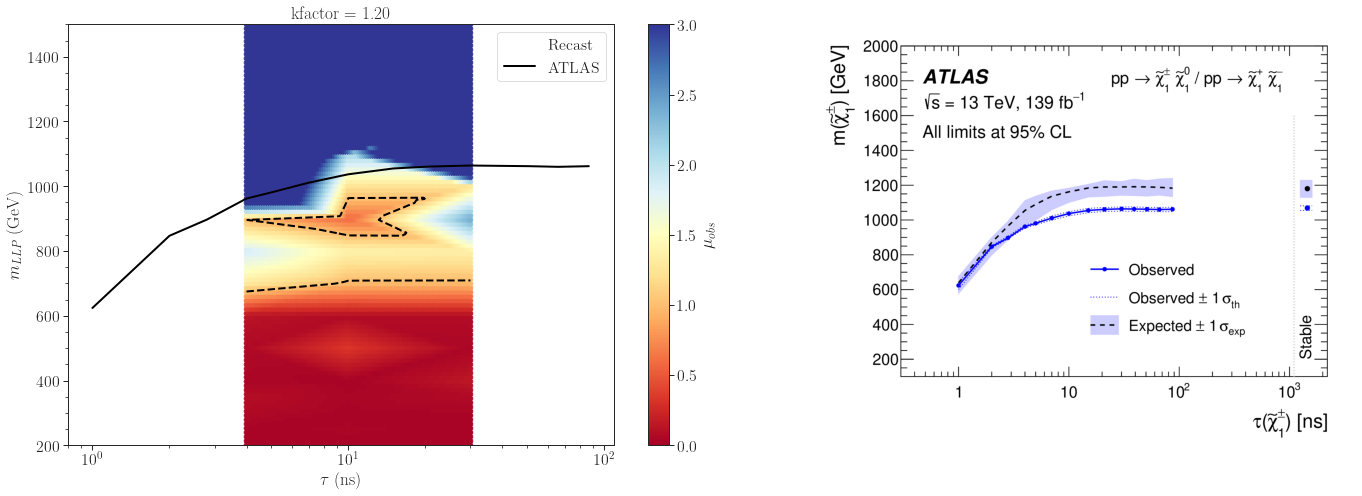

In [29]:
fig,ax = plt.subplots(figsize=(20,7),ncols=2,nrows=1)


p = ax[0].scatter(x=pts[:,0],y=pts[:,1],vmin=0.0,vmax=3.0,
            c=muPts,cmap=cm)
cbar = plt.colorbar(p,label=r'$\mu_{obs}$',ax=ax[0])
cs = ax[0].tricontour(pts[:,0],pts[:,1],muPts,levels=[1.0],
               linewidths=2,linestyles='dashed',colors='black')
cs.collections[0].set_label('Recast')

ax[0].plot(atlasCurve["Lifetime_ns"],atlasCurve["Observed_Limit_GeV"],label='ATLAS',linewidth=2,color='black')
ax[0].legend(loc='upper right')
ax[0].set_xlabel(r'$\tau$ (ns)')
ax[0].set_ylabel(r'$m_{LLP}$ (GeV)')
ax[0].set_xscale('log')
# ax[0].set_ylim(-10,1500)
# ax[0].set_xlim(0,3000)
ax[0].minorticks_on()
# ax[0].text(0.05,0.6,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
#          transform = ax[0].transAxes)
ax[0].set_title('kfactor = %1.2f' %kfactor)

cmsPlot = plt.imread('../ATLAS_data/fig_17a.png')
ax[1].imshow(cmsPlot)
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [30]:
import itertools

In [36]:
pairs1 = list(itertools.product(np.linspace(1.,3.5,5),np.linspace(500.,1200.,10)))
pairs1 = [(float('%1.2f'%x[0]),float('%1.0f' %x[1])) for x in pairs]

In [37]:
pairs2 = list(itertools.product(np.logspace(1.5,2,5),np.linspace(500.,1200.,10)))
pairs2 = [(float('%1.2f'%x[0]),float('%1.0f' %x[1])) for x in pairs]
pairs = pairs1 + pairs2
print(len(pairs))
print(pairs)

100
[(31.62, 500.0), (31.62, 578.0), (31.62, 656.0), (31.62, 733.0), (31.62, 811.0), (31.62, 889.0), (31.62, 967.0), (31.62, 1044.0), (31.62, 1122.0), (31.62, 1200.0), (42.17, 500.0), (42.17, 578.0), (42.17, 656.0), (42.17, 733.0), (42.17, 811.0), (42.17, 889.0), (42.17, 967.0), (42.17, 1044.0), (42.17, 1122.0), (42.17, 1200.0), (56.23, 500.0), (56.23, 578.0), (56.23, 656.0), (56.23, 733.0), (56.23, 811.0), (56.23, 889.0), (56.23, 967.0), (56.23, 1044.0), (56.23, 1122.0), (56.23, 1200.0), (74.99, 500.0), (74.99, 578.0), (74.99, 656.0), (74.99, 733.0), (74.99, 811.0), (74.99, 889.0), (74.99, 967.0), (74.99, 1044.0), (74.99, 1122.0), (74.99, 1200.0), (100.0, 500.0), (100.0, 578.0), (100.0, 656.0), (100.0, 733.0), (100.0, 811.0), (100.0, 889.0), (100.0, 967.0), (100.0, 1044.0), (100.0, 1122.0), (100.0, 1200.0), (31.62, 500.0), (31.62, 578.0), (31.62, 656.0), (31.62, 733.0), (31.62, 811.0), (31.62, 889.0), (31.62, 967.0), (31.62, 1044.0), (31.62, 1122.0), (31.62, 1200.0), (42.17, 500.0), (